# Analysis of Results
* Results were computed in `Evaluation.ipynb`
* In this notebook, we play with the results to gain further insights.

In [128]:
import os
from os.path import join
from scripts.scoring import create_matrix_from_csv

res_files = os.listdir('direct_results')
direct_res = {f.replace('.csv', ''):{'file':join('direct_results', f), 'BLEU':None} for f in res_files}

for rs, content in direct_res.items():
    file_path = content['file']
    df = create_matrix_from_csv(file_path)
    direct_res[rs]['BLEU'] = df
    
    
res_files = os.listdir('post_results')
post_res = {f.replace('.csv', ''): {'file': join(
    'post_results', f), 'BLEU': None, 'CHRF':None} for f in res_files}

for rs, content in post_res.items():
    file_path = content['file']
    df_bleu = create_matrix_from_csv(file_path)
    df_chrf = create_matrix_from_csv(file_path, metric='chrF')
    post_res[rs]['BLEU'] = df_bleu
    post_res[rs]['CHRF'] = df_chrf

## Pearson Correlation

* Correlation between both translators
* We perform this on the direct aligned and post aligned results
    * Direct: We literally computed BLEU scores directly on the translation, without doing any alignments.
    * Post: We applied `bertalign` and sentence splitting to align everything nicely.

In [129]:
import numpy as np
from scipy.stats import pearsonr
# ChatGPT aided
parts = ['ep', 'flores', 'opus']

print('direct_results')
for part in parts:
    gpt = f'{part}-gpt'
    deepl = f'{part}-deepl'
    gpt_df = direct_res[gpt]['BLEU']
    deepl_df = direct_res[deepl]['BLEU']

    # flattens whole matrix into 1D-array
    gpt_flat = gpt_df.values.flatten()
    deepl_flat = deepl_df.values.flatten()

    mask = ~np.isnan(gpt_flat) & ~np.isnan(deepl_flat)

    # Compute Pearson correlation
    corr, pval = pearsonr(gpt_flat[mask], deepl_flat[mask])
    print(part)
    print(f"Pearson correlation: {corr:.2f}")
    print(f"p-value: {pval:.3f}")
    print()
    
print('post_results')
for part in parts:
    gpt = f'{part}-gpt'
    deepl = f'{part}-deepl'
    gpt_df = post_res[gpt]['BLEU']
    deepl_df = post_res[deepl]['BLEU']

    gpt_flat = gpt_df.values.flatten()
    deepl_flat = deepl_df.values.flatten()

    mask = ~np.isnan(gpt_flat) & ~np.isnan(deepl_flat)

    # Compute Pearson correlation
    corr, pval = pearsonr(gpt_flat[mask], deepl_flat[mask])
    print(part)
    print(f"Pearson correlation: {corr:.2f}")
    print(f"p-value: {pval:.3f}")
    print()

direct_results
ep
Pearson correlation: 0.61
p-value: 0.000

flores
Pearson correlation: 0.80
p-value: 0.000

opus
Pearson correlation: 0.30
p-value: 0.206

post_results
ep
Pearson correlation: 0.93
p-value: 0.000

flores
Pearson correlation: 0.96
p-value: 0.000

opus
Pearson correlation: 0.96
p-value: 0.000



* Observe, statistical significance went up after alignment, especially for OPUS100

* Next, we compute correlation between BLEU and CHRF scores.

In [130]:
import numpy as np
from scipy.stats import pearsonr

parts = ['ep', 'flores', 'opus']
translators = ['deepl', 'gpt']

for part in parts:
    for tl in translators:
        key = f'{part}-{tl}'
        bleu_mat = post_res[key]['BLEU']
        chrf_mat = post_res[key]['CHRF']
        
        
        bleu_flat = bleu_mat.values.flatten()
        chrf_flat = chrf_mat.values.flatten()

        mask = ~np.isnan(bleu_flat) & ~np.isnan(chrf_flat)

        corr, pval = pearsonr(bleu_flat[mask], chrf_flat[mask])
        print(part, tl)
        print(f"Pearson correlation: {corr:.2f}")
        print(f"p-value: {pval:.5f}")
        print()

ep deepl
Pearson correlation: 0.83
p-value: 0.00000

ep gpt
Pearson correlation: 0.87
p-value: 0.00000

flores deepl
Pearson correlation: 0.94
p-value: 0.00000

flores gpt
Pearson correlation: 0.95
p-value: 0.00000

opus deepl
Pearson correlation: 0.85
p-value: 0.00000

opus gpt
Pearson correlation: 0.88
p-value: 0.00000



### Plotting

In [131]:
from collections import defaultdict

def topk_label_based_on_freq(labels, k=3):
    freq_dict = defaultdict(int)
    for l in labels:
        from_l, to_l = l.split('-')
        freq_dict[f'to-{to_l}'] += 1
        freq_dict[f'from-{from_l}'] += 1
    
    print(f'top {k}')
    for idx, (key, v) in enumerate(sorted(freq_dict.items(), key=lambda x : x[1], reverse=True)):
        if idx >= k:
            break
        print('\t', key)
    return freq_dict

* Let's do some graphing on EuroParl, DeepL, has the lowest Pearson correlation compared to the others

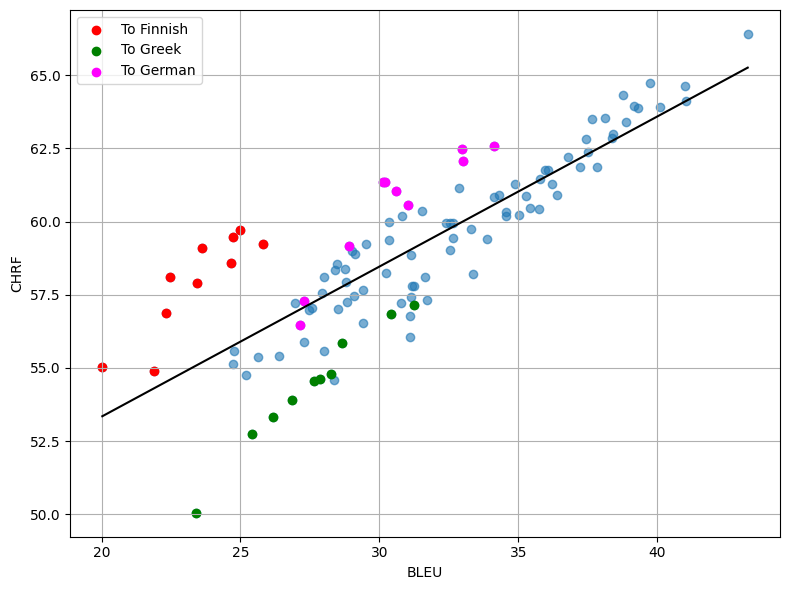

In [132]:
import matplotlib.pyplot as plt
# ChatGPT aided

bleu = post_res['ep-deepl']['BLEU']
chrf = post_res['ep-deepl']['CHRF']

bleu_vals, chrf_vals = [], []
labels = []

for src in bleu.index:
    for tgt in bleu.columns:
        if src==tgt:
            continue
        bs = bleu.loc[src, tgt]
        cs = chrf.loc[src, tgt]
        bleu_vals.append(bs)
        chrf_vals.append(cs)
        labels.append(f'{src}-{tgt}')


bleu_vals_np = np.array(bleu_vals)
chrf_vals_np = np.array(chrf_vals)


# Plot all points
plt.figure(figsize=(8, 6))
plt.scatter(bleu_vals, chrf_vals, alpha=0.6)

model = np.polyfit(bleu_vals_np, chrf_vals_np, 1)


to_finnish = [idx for idx, pair in enumerate(labels) if pair.endswith('fi')]
to_greek = [idx for idx, pair in enumerate(labels) if pair.endswith('el')]
to_german = [idx for idx, pair in enumerate(labels) if pair.endswith('de')]

plt.scatter(
    bleu_vals_np[to_finnish],
    chrf_vals_np[to_finnish],
    color='red',
    label='To Finnish'
)

plt.scatter(
    bleu_vals_np[to_greek],
    chrf_vals_np[to_greek],
    color='green',
    label='To Greek'
)

plt.scatter(
    bleu_vals_np[to_german],
    chrf_vals_np[to_german],
    color='magenta',
    label='To German'
)



x_line = np.linspace(min(bleu_vals_np), max(bleu_vals_np), 100)
y_line = model[0] * x_line + model[1]
plt.plot(x_line, y_line, color='black')


plt.xlabel("BLEU")
plt.ylabel("CHRF")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [133]:
# Based on: https://data36.com/linear-regression-in-python-numpy-polyfit/
# ChatGPT aided as well
predicted_chrf = np.poly1d(model)(bleu_vals_np)
residuals = abs(chrf_vals_np - predicted_chrf)

top_n = 20
outlier_indices = np.argsort(residuals)[-top_n:]

outlier_labels = []
for idx in outlier_indices:
    print(f"{labels[idx]} {bleu_vals_np[idx]:.1f}, {chrf_vals_np[idx]:.2f}")
    outlier_labels.append(labels[idx])

_ = topk_label_based_on_freq(outlier_labels)

sv-fi 22.3, 56.87
es-de 33.0, 62.50
fr-el 27.6, 54.55
sv-el 27.9, 54.63
da-el 28.3, 54.79
el-de 30.2, 61.36
pt-fi 23.4, 57.89
fr-de 30.1, 61.37
de-fi 24.7, 58.59
da-fi 25.8, 59.23
de-el 26.9, 53.89
nl-es 31.1, 56.04
nl-pt 28.4, 54.58
it-el 26.2, 53.31
fi-el 25.4, 52.74
fr-fi 22.4, 58.09
en-fi 24.7, 59.46
es-fi 25.0, 59.71
el-fi 23.6, 59.11
nl-el 23.4, 50.05
top 3
	 to-fi
	 to-el
	 to-de


* Iterative process, this was done first, then To German, To Finnish and To Greek pairs were marked.
* The graph tells us that CHRF considers quality of into Finnish translations higher and into Greek lower than BLEU.

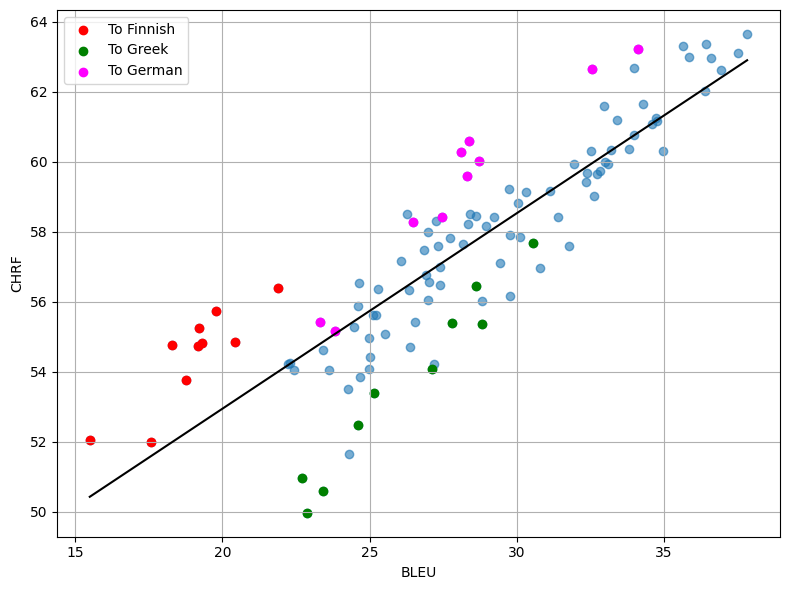

In [134]:
import matplotlib.pyplot as plt
# ChatGPT aided

bleu = post_res['ep-gpt']['BLEU']
chrf = post_res['ep-gpt']['CHRF']

bleu_vals, chrf_vals = [], []
labels = []

for src in bleu.index:
    for tgt in bleu.columns:
        if src == tgt:
            continue
        bs = bleu.loc[src, tgt]
        cs = chrf.loc[src, tgt]
        bleu_vals.append(bs)
        chrf_vals.append(cs)
        labels.append(f'{src}-{tgt}')


bleu_vals_np = np.array(bleu_vals)
chrf_vals_np = np.array(chrf_vals)


# Plot all points
plt.figure(figsize=(8, 6))
plt.scatter(bleu_vals, chrf_vals, alpha=0.6)

model = np.polyfit(bleu_vals_np, chrf_vals_np, 1)


to_finnish = [idx for idx, pair in enumerate(labels) if pair.endswith('fi')]
to_greek = [idx for idx, pair in enumerate(labels) if pair.endswith('el')]
to_german = [idx for idx, pair in enumerate(labels) if pair.endswith('de')]

plt.scatter(
    bleu_vals_np[to_finnish],
    chrf_vals_np[to_finnish],
    color='red',
    label='To Finnish'
)

plt.scatter(
    bleu_vals_np[to_greek],
    chrf_vals_np[to_greek],
    color='green',
    label='To Greek'
)

plt.scatter(
    bleu_vals_np[to_german],
    chrf_vals_np[to_german],
    color='magenta',
    label='To German'
)


x_line = np.linspace(min(bleu_vals_np), max(bleu_vals_np), 100)
y_line = model[0] * x_line + model[1]
plt.plot(x_line, y_line, color='black')


plt.xlabel("BLEU")
plt.ylabel("CHRF")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [135]:
# Based on: https://data36.com/linear-regression-in-python-numpy-polyfit/
# ChatGPT aided as well
predicted_chrf = np.poly1d(model)(bleu_vals_np)
residuals = abs(chrf_vals_np - predicted_chrf)

top_n = 20
outlier_indices = np.argsort(residuals)[-top_n:]

outlier_labels = []
for idx in outlier_indices:
    print(f"{labels[idx]} {bleu_vals_np[idx]:.1f}, {chrf_vals_np[idx]:.2f}")
    outlier_labels.append(labels[idx])

_ = topk_label_based_on_freq(outlier_labels)

sv-fi 19.2, 54.72
nl-es 29.8, 56.16
es-fi 19.3, 54.81
da-fi 21.9, 56.38
da-de 34.1, 63.22
it-el 25.2, 53.40
en-el 28.8, 55.36
es-de 32.6, 62.64
de-pt 27.2, 54.23
en-fi 19.2, 55.25
fr-fi 18.3, 54.76
el-de 28.1, 60.28
da-el 27.1, 54.07
el-fi 19.8, 55.72
pt-de 28.4, 60.60
sv-el 24.6, 52.46
fi-el 22.7, 50.96
nl-pt 24.3, 51.65
de-el 23.4, 50.60
nl-el 22.9, 49.97
top 3
	 to-el
	 to-fi
	 to-de


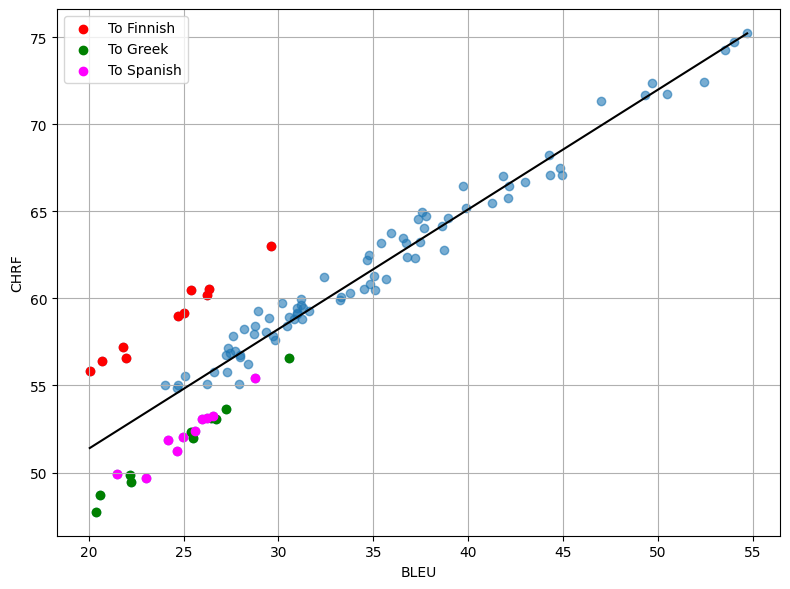

In [136]:
import matplotlib.pyplot as plt
# ChatGPT aided

bleu = post_res['flores-deepl']['BLEU']
chrf = post_res['flores-deepl']['CHRF']

bleu_vals, chrf_vals = [], []
labels = []

for src in bleu.index:
    for tgt in bleu.columns:
        if src == tgt:
            continue
        bs = bleu.loc[src, tgt]
        cs = chrf.loc[src, tgt]
        bleu_vals.append(bs)
        chrf_vals.append(cs)
        labels.append(f'{src}-{tgt}')


bleu_vals_np = np.array(bleu_vals)
chrf_vals_np = np.array(chrf_vals)


# Plot all points
plt.figure(figsize=(8, 6))
plt.scatter(bleu_vals, chrf_vals, alpha=0.6)

model = np.polyfit(bleu_vals_np, chrf_vals_np, 1)


to_finnish = [idx for idx, pair in enumerate(labels) if pair.endswith('fi')]
to_greek = [idx for idx, pair in enumerate(labels) if pair.endswith('el')]
to_spanish = [idx for idx, pair in enumerate(labels) if pair.endswith('es')]

plt.scatter(
    bleu_vals_np[to_finnish],
    chrf_vals_np[to_finnish],
    color='red',
    label='To Finnish'
)

plt.scatter(
    bleu_vals_np[to_greek],
    chrf_vals_np[to_greek],
    color='green',
    label='To Greek'
)

plt.scatter(
    bleu_vals_np[to_spanish],
    chrf_vals_np[to_spanish],
    color='magenta',
    label='To Spanish'
)


x_line = np.linspace(min(bleu_vals_np), max(bleu_vals_np), 100)
y_line = model[0] * x_line + model[1]
plt.plot(x_line, y_line, color='black')


plt.xlabel("BLEU")
plt.ylabel("CHRF")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [137]:
# Based on: https://data36.com/linear-regression-in-python-numpy-polyfit/
# ChatGPT aided as well
predicted_chrf = np.poly1d(model)(bleu_vals_np)
residuals = abs(chrf_vals_np - predicted_chrf)

threshold = 3
outlier_indices = np.where(residuals > threshold)[0]

top_n = 20
outlier_indices = np.argsort(residuals)[-top_n:]

outlier_labels = []
for idx in outlier_indices:
    print(f"{labels[idx]} {bleu_vals_np[idx]:.1f}, {chrf_vals_np[idx]:.2f}")
    outlier_labels.append(labels[idx])

_ = topk_label_based_on_freq(outlier_labels)

fr-el 25.4, 52.35
sv-es 25.6, 52.40
sv-el 26.7, 53.07
it-el 22.2, 49.83
es-el 20.6, 48.71
de-el 25.5, 52.01
el-es 24.7, 51.24
fi-el 22.2, 49.45
nl-es 23.0, 49.67
nl-fi 22.0, 56.56
nl-el 20.4, 47.75
fr-fi 25.0, 59.17
pt-fi 24.7, 58.99
es-fi 20.1, 55.84
de-fi 26.3, 60.18
it-fi 20.7, 56.38
el-fi 21.8, 57.21
da-fi 26.3, 60.54
en-fi 29.6, 62.99
sv-fi 25.4, 60.47
top 3
	 to-fi
	 to-el
	 to-es


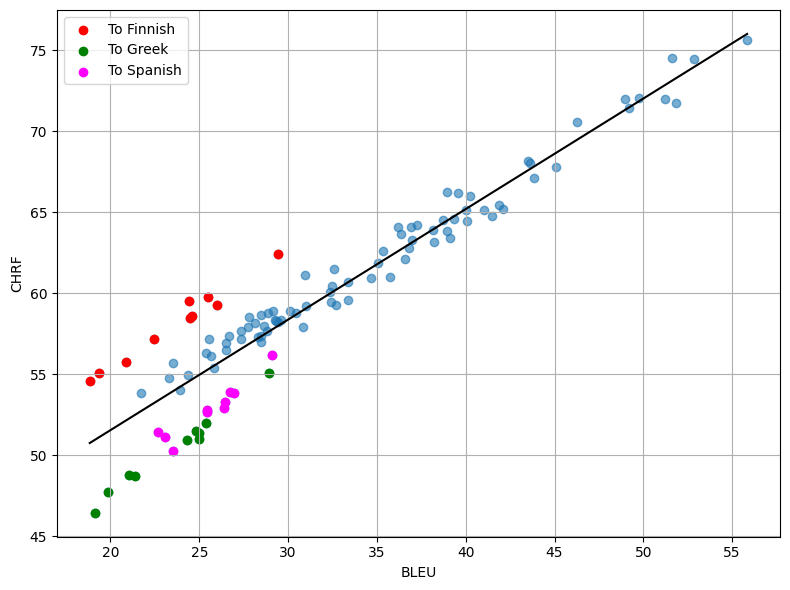

In [138]:
import matplotlib.pyplot as plt
# ChatGPT aided

bleu = post_res['flores-gpt']['BLEU']
chrf = post_res['flores-gpt']['CHRF']

bleu_vals, chrf_vals = [], []
labels = []

for src in bleu.index:
    for tgt in bleu.columns:
        if src == tgt:
            continue
        bs = bleu.loc[src, tgt]
        cs = chrf.loc[src, tgt]
        bleu_vals.append(bs)
        chrf_vals.append(cs)
        labels.append(f'{src}-{tgt}')


bleu_vals_np = np.array(bleu_vals)
chrf_vals_np = np.array(chrf_vals)


# Plot all points
plt.figure(figsize=(8, 6))
plt.scatter(bleu_vals, chrf_vals, alpha=0.6)

model = np.polyfit(bleu_vals_np, chrf_vals_np, 1)


to_finnish = [idx for idx, pair in enumerate(labels) if pair.endswith('fi')]
to_greek = [idx for idx, pair in enumerate(labels) if pair.endswith('el')]
to_spanish = [idx for idx, pair in enumerate(labels) if pair.endswith('es')]


plt.scatter(
    bleu_vals_np[to_finnish],
    chrf_vals_np[to_finnish],
    color='red',
    label='To Finnish'
)

plt.scatter(
    bleu_vals_np[to_greek],
    chrf_vals_np[to_greek],
    color='green',
    label='To Greek'
)

plt.scatter(
    bleu_vals_np[to_spanish],
    chrf_vals_np[to_spanish],
    color='magenta',
    label='To Spanish'
)


x_line = np.linspace(min(bleu_vals_np), max(bleu_vals_np), 100)
y_line = model[0] * x_line + model[1]
plt.plot(x_line, y_line, color='black')


plt.xlabel("BLEU")
plt.ylabel("CHRF")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [139]:
# Based on: https://data36.com/linear-regression-in-python-numpy-polyfit/
# ChatGPT aided as well
predicted_chrf = np.poly1d(model)(bleu_vals_np)
residuals = abs(chrf_vals_np - predicted_chrf)

top_n = 30
outlier_indices = np.argsort(residuals)[-top_n:]

outlier_labels = []
for idx in outlier_indices:
    print(f"{labels[idx]} {bleu_vals_np[idx]:.1f}, {chrf_vals_np[idx]:.2f}")
    outlier_labels.append(labels[idx])

_ = topk_label_based_on_freq(outlier_labels)
_

it-es 22.7, 51.46
en-nl 30.9, 61.12
fr-es 26.7, 53.90
da-es 26.9, 53.85
pt-es 25.5, 52.81
fi-es 23.1, 51.12
en-el 28.9, 55.10
el-es 25.4, 52.69
sv-es 26.4, 53.29
de-es 26.4, 52.91
da-el 25.4, 52.01
sv-el 24.8, 51.48
it-el 21.1, 48.78
pt-el 24.3, 50.95
fr-el 25.0, 51.40
it-fi 20.9, 55.73
de-fi 26.0, 59.25
nl-es 23.5, 50.27
fi-el 21.4, 48.75
es-el 19.9, 47.72
nl-fi 18.8, 54.57
fr-fi 24.5, 58.47
pt-fi 24.6, 58.60
de-el 25.0, 51.01
el-fi 22.5, 57.20
es-fi 19.3, 55.10
en-fi 29.4, 62.43
da-fi 25.5, 59.77
nl-el 19.2, 46.46
sv-fi 24.4, 59.50
top 3
	 to-el
	 to-fi
	 to-es


defaultdict(int,
            {'to-es': 9,
             'from-it': 3,
             'to-nl': 1,
             'from-en': 3,
             'from-fr': 3,
             'from-da': 3,
             'from-pt': 3,
             'from-fi': 2,
             'to-el': 10,
             'from-el': 2,
             'from-sv': 3,
             'from-de': 3,
             'to-fi': 10,
             'from-nl': 3,
             'from-es': 2})